In [90]:
!pip install haversine
import glob
import itertools
import json
import os
import warnings
import re
warnings.filterwarnings('ignore')
import sys, os, csv
try:
    import navpy
except ImportError as e:
    !pip install navpy
    import navpy

# import geopandas as gpd
# from geopandas import GeoDataFrame
# import geoplot as gplt
from IPython.display import Video
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import plotly.express as px
import pynmea2
import requests
import seaborn as sns
from shapely.geometry import Point, shape
import shapely.wkt
from pandas.plotting import scatter_matrix
from haversine import haversine, Unit
import scipy
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option("precision", 8)
%matplotlib inline
from scipy import stats



In [2]:
#functions to calculate distance between two ll coordinates: 

def calc_haversine(lat1, lon1, lat2, lon2):
    '''Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    '''
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist


'''functions for simple algorithm to derive estimated receiver position based on semi-raw measurements (xs= satellite positions in x,y,x plane (must be an array), 
 measured pseudorange from ground to satellite position,x0= assessed location of receiver, b0=clock bias at receiver) )
'''


def least_squares(xs, measured_pseudorange, x0, b0):
    dx = 100*np.ones(3)
    b = b0
    # set up the G matrix with the right dimensions. We will later replace the first 3 columns
    # note that b here is the clock bias in meters equivalent, so the actual clock bias is b/LIGHTSPEED
    G = np.ones((measured_pseudorange.size, 4))
    iterations = 0
    while np.linalg.norm(dx) > 1e-3:
        # Eq. (2):
        r = np.linalg.norm(xs - x0, axis=1)
        # Eq. (1):
        phat = r + b0
        # Eq. (3):
        deltaP = measured_pseudorange - phat
        G[:, 0:3] = -(xs - x0) / r[:, None]
        # Eq. (4):
        sol = np.linalg.inv(np.transpose(G) @ G) @ np.transpose(G) @ deltaP
        # Eq. (5):
        dx = sol[0:3]
        db = sol[3]
        x0 = x0 + dx
        b0 = b0 + db
    norm_dp = np.linalg.norm(deltaP)
    return x0, b0, norm_dp

''' given a df which holds satellite positional data, prm and estimated phone locations, this function will use the least squares function to provide a single estimated location for each array of satellite positions and pseudorange
provide in the df. each estimated location requires at least 4 satellite positional reading for each epoch that we want to calculate a location for'''

def generate_rcvr_positions_by_constType(df):
    ests_array_lat = np.zeros(len(df))
    ests_array_lon = np.zeros(len(df))
    ests_array_alt = np.zeros(len(df))
    satb_array = np.zeros(len(df))
    satdp_array = np.zeros(len(df))
    dists = np.zeros(len(df))
    
    for each in range(0, df['epoch'].max()+1):
        try:
            each_epoch = df.query('epoch == @each')
            Sat_Array = each_epoch[['xSatPosM', 'ySatPosM', 'zSatPosM', 'correctPrM']]
            xs= Sat_Array[['xSatPosM', 'ySatPosM', 'zSatPosM']].to_numpy()
            pr = Sat_Array['correctPrM'].to_numpy()
            b0 = 0
            x0 = np.array([0, 0, 0])
            satx, satb, satdp = least_squares(xs, pr, x0, b0)
            ests_array_lat[each], ests_array_lon[each], ests_array_alt[each] = navpy.ecef2lla(satx)
            satdp_array[each]=satdp
            satb_array[each]=satb
            dists[each] = haversine((each_epoch['gt_latDeg'].min(),each_epoch['gt_lngDeg'].min()), (ests_array_lat[each], ests_array_lon[each]), unit=Unit.METERS)
            df['est_latDeg']= ests_array_lat[df['epoch']]
            df['est_lngDeg']= ests_array_lon[df['epoch']]
            df['rcvr_bias'] = satb_array[df['epoch']]
            df['residual_error'] = satdp_array[df['epoch']]
            df['dists_inMeters'] = dists[df['epoch']]
        except:
            pass
    return df

def epochs_for_constSystem(df, ConstType):
        new_df = df.loc[df['constellationType']== ConstType]
        new_df = new_df.reset_index()
        return new_df

In [3]:
consttype_list = ['GLONASS', 'GPS', 'BEIDOU', 'GALILEO']


derived_locs = pd.read_csv('data/Mi8_derived.csv')
ground_truth = pd.read_csv('data/ground_truth.csv')
#Add DTG column by modifying gps epoch time (1980) to DTG format 
dt_offset = pd.to_datetime('1980-01-06 00:00:00')
print(dt_offset)
dt_offset_in_ms = int(dt_offset.value / 1e6)
ground_truth['dtg'] = pd.to_datetime(ground_truth['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
derived_locs['dtg'] = pd.to_datetime(derived_locs['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')


derived_locs['correctPrM'] = (derived_locs['rawPrM'] + derived_locs['satClkBiasM'] - derived_locs['isrbM'] - 
                           derived_locs['ionoDelayM'] - derived_locs['tropoDelayM'])



derived_locs = derived_locs[['collectionName', 'phoneName', 'dtg', 'millisSinceGpsEpoch',
       'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
       'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
       'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM','correctPrM', 'rawPrUncM',
       'isrbM', 'ionoDelayM', 'tropoDelayM']]

1980-01-06 00:00:00


In [132]:
ground_truth = ground_truth.rename(columns={"latDeg": "gt_latDeg", "lngDeg": "gt_lngDeg"})
cols = ['millisSinceGpsEpoch', 'gt_latDeg', 'gt_lngDeg','timeSinceFirstFixSeconds', 'hDop', 'vDop', 'speedMps', 'courseDegree' ]

df = derived_locs.merge(ground_truth[cols], how='inner', on='millisSinceGpsEpoch', 
                    suffixes=('_gt', ''))

sat_dict = { 0: 'UNK',
             1: 'GPS',
             2: 'SBAS',
             3: 'GLONASS',
             4: 'QZSS',
             5: 'BEIDOU',
             6: 'GALILEO',
             7: 'IRNSS'
       }

signal_type = {'GLO_G1': 'RUS ',
               'GLO_G5': 'RUS ',
               'GPS_L1': 'US ',
               'GPS_L5': 'US ',
               'BDS_B1I': 'CHN ',
               'BDS_B5' : 'CHN ',
               'GAL_E5A' : 'EU',
               'GAL_E1' : 'EU',
               'QZS_J1' : 'JPN',
               'QZS_J5' : 'JPN'
              }
    
df = df.replace({'constellationType':sat_dict})
df['svName'] = df['constellationType'] + df['svid'].astype(str)
#modify millis to seconds: 
df['secondsSinceGPSEpoch'] = df['millisSinceGpsEpoch'] / 1000
df['secondsSinceGPSEpoch'] = df['secondsSinceGPSEpoch'].astype(int)



df['svName'] = df['constellationType'] + df['svid'].astype(str)
df['epoch'] = 0

In [133]:
df= df.replace({'signalType': signal_type})

In [134]:
df['epoch'] = df['secondsSinceGPSEpoch'] - df['secondsSinceGPSEpoch'][0]

In [7]:
#determine the length of time for each dataframe of measurements 
df.dtg.tail()[-1:] - df.dtg.head()[0]

76172   0 days 00:41:38
Name: dtg, dtype: timedelta64[ns]

In [8]:
len(df)

76173

No handles with labels found to put in legend.


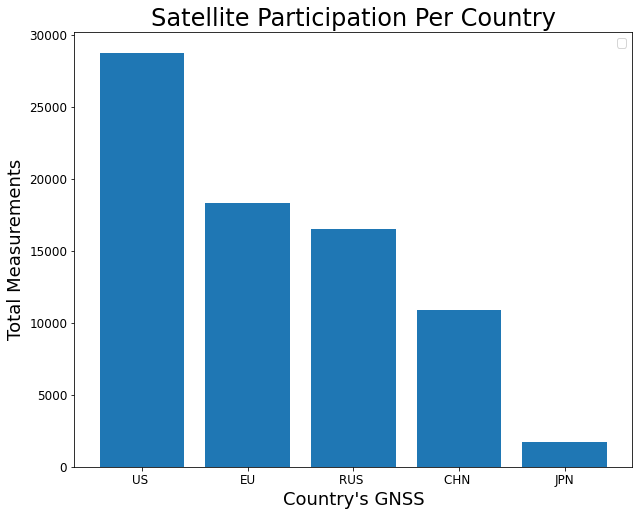

In [135]:
#bar plot to see how many satellite measurements per country were used to compute locations in the 41 minute drive: 
#df.signalType.value_counts().plot(kind='bar', title='Satellite Participation Per Country', fontsize=18)

fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams.update({'font.size': 12})
ax.bar(df.signalType.value_counts().index, df.signalType.value_counts().values)
ax.set_xlabel("Country's GNSS", fontsize=18)
ax.set_ylabel('Total Measurements', fontsize=18)
ax.set_title('Satellite Participation Per Country', fontsize=24)
ax.legend()
plt.savefig('images/Total Sats Used Per Country')

In [10]:
list_of_countries = [epochs_for_constSystem(df, constType) for constType in consttype_list]

In [11]:
rus_sats, usa_sats, china_sats, eu_sats = [generate_rcvr_positions_by_constType(country) for country in list_of_countries]

<AxesSubplot:>

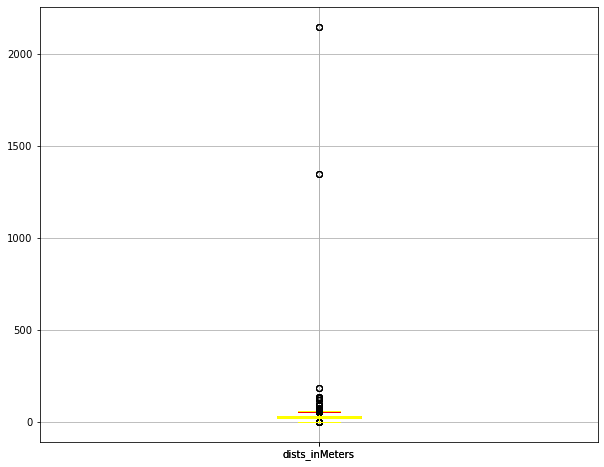

In [16]:
usa_sats.boxplot(column='dists_inMeters', figsize=(10,8), color='red')
rus_sats.boxplot(column='dists_inMeters', figsize=(10,8), color = 'yellow')

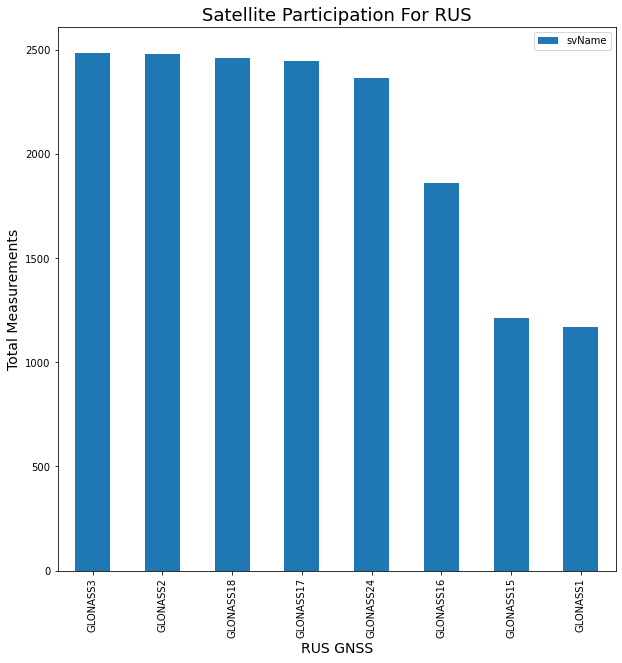

In [104]:
fig,ax = plt.subplots(figsize=(10,10))
rus_sats.svName.value_counts().plot(kind='bar')
ax.set_xlabel("RUS GNSS", fontsize=14)
ax.set_ylabel('Total Measurements', fontsize=14)
ax.set_title('Satellite Participation For RUS', fontsize=18)
ax.legend()
plt.savefig('images/Satellite Participation For RUS')

In [15]:
# fig, ax = plt.subplots(figsize=(10,8))
# ax.bar(usa_sats.dists_inMeters.value_counts().index, usa_sats.dists_inMeters.value_counts().values)

In [17]:
#dictionary to use when creating a pivot table in order to group all data by epoch and count how many satellites were used to determine 
#each computed location. Field for count of satellites used is 'constellationType'
agg_func_dict = {'constellationType': 'count', 
                 'xSatVelMps': 'mean', 
                 'ySatVelMps': 'mean',
                 'zSatVelMps': 'mean', 
                 'satClkBiasM': 'mean', 
                 'satClkDriftMps': 'mean', 
                 'rawPrM': 'mean', 
                 'correctPrM': 'mean',
                 'rawPrUncM': 'mean', 
                 'isrbM': 'mean', 
                 'ionoDelayM': 'mean', 
                 'tropoDelayM': 'mean', 
                 'timeSinceFirstFixSeconds':'mean', 
                 'speedMps':'mean',
                 'rcvr_bias':'mean', 
                 'residual_error':'mean', 
                 'dists_inMeters':'mean'}

In [14]:
#table df is built from sats df  and is the sats data as it pertains to each epoch 
usa_table = usa_sats.pivot_table(usa_sats,index=['epoch'],aggfunc=agg_func_dict)

In [18]:
rus_table = rus_sats.pivot_table(rus_sats,index=['epoch'], aggfunc=agg_func_dict)
china_table = china_sats.pivot_table(china_sats,index=['epoch'],aggfunc=agg_func_dict)
eu_table = eu_sats.pivot_table(eu_sats,index=['epoch'], aggfunc=agg_func_dict)

In [19]:
china_table.loc[china_table.constellationType < 4]

,constellationType,correctPrM,dists_inMeters,ionoDelayM,isrbM,rawPrM,rawPrUncM,rcvr_bias,residual_error,satClkBiasM,satClkDriftMps,speedMps,timeSinceFirstFixSeconds,tropoDelayM,xSatVelMps,ySatVelMps,zSatVelMps
epoch,,,,,,,,,,,,,,,,,
247,3,22811762.21333,0.00000,2.71000,2.70500,22836311.85033,2.29833,0.00000,0.00000,-24540.44967,0.00067,0.00000,403.00000,3.77233,1012.81233,-1045.87833,1033.47833
248,3,22811523.20400,0.00000,2.71000,5.27900,22836075.41400,2.29833,0.00000,0.00000,-24540.44967,0.00067,0.00000,404.00000,3.77133,1012.80300,-1045.87767,1033.14567
253,3,22810342.09133,0.00000,2.71000,3.71400,22834892.73267,2.19867,0.00000,0.00000,-24540.44800,0.00067,0.00000,409.00000,3.76933,1012.75633,-1045.87433,1031.48233
263,3,22807984.74733,0.00000,2.71000,2.39800,22832534.06567,2.09867,0.00000,0.00000,-24540.44500,0.00067,0.00000,419.00000,3.76533,1012.66233,-1045.86700,1028.15400
264,3,22807748.71133,0.00000,2.71000,3.59700,22832299.22800,2.09867,0.00000,0.00000,-24540.44500,0.00067,0.00000,420.00000,3.76467,1012.65300,-1045.86633,1027.82100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,3,22425544.19867,0.00000,2.74800,4.32900,22450094.22300,2.39867,0.00000,0.00000,-24539.77467,0.00067,0.00000,2596.00000,3.17267,965.40767,-1005.86067,269.52867
2441,3,22425429.85267,0.00000,2.74833,2.15600,22449977.70400,2.39867,0.00000,0.00000,-24539.77433,0.00067,0.00000,2597.00000,3.17267,965.37567,-1005.82400,269.16967
2442,3,22425313.46233,0.00000,2.74833,2.82700,22449861.98400,2.49833,0.00000,0.00000,-24539.77400,0.00067,0.00000,2598.00000,3.17233,965.34400,-1005.78700,268.81067


In [20]:
china_table.dists_inMeters.value_counts()
china_table.loc[china_table.dists_inMeters == 0.00000]

,constellationType,correctPrM,dists_inMeters,ionoDelayM,isrbM,rawPrM,rawPrUncM,rcvr_bias,residual_error,satClkBiasM,satClkDriftMps,speedMps,timeSinceFirstFixSeconds,tropoDelayM,xSatVelMps,ySatVelMps,zSatVelMps
epoch,,,,,,,,,,,,,,,,,
247,3,22811762.21333,0.00000,2.71000,2.70500,22836311.85033,2.29833,0.00000,0.00000,-24540.44967,0.00067,0.00000,403.00000,3.77233,1012.81233,-1045.87833,1033.47833
248,3,22811523.20400,0.00000,2.71000,5.27900,22836075.41400,2.29833,0.00000,0.00000,-24540.44967,0.00067,0.00000,404.00000,3.77133,1012.80300,-1045.87767,1033.14567
253,3,22810342.09133,0.00000,2.71000,3.71400,22834892.73267,2.19867,0.00000,0.00000,-24540.44800,0.00067,0.00000,409.00000,3.76933,1012.75633,-1045.87433,1031.48233
263,3,22807984.74733,0.00000,2.71000,2.39800,22832534.06567,2.09867,0.00000,0.00000,-24540.44500,0.00067,0.00000,419.00000,3.76533,1012.66233,-1045.86700,1028.15400
264,3,22807748.71133,0.00000,2.71000,3.59700,22832299.22800,2.09867,0.00000,0.00000,-24540.44500,0.00067,0.00000,420.00000,3.76467,1012.65300,-1045.86633,1027.82100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,3,22425544.19867,0.00000,2.74800,4.32900,22450094.22300,2.39867,0.00000,0.00000,-24539.77467,0.00067,0.00000,2596.00000,3.17267,965.40767,-1005.86067,269.52867
2441,3,22425429.85267,0.00000,2.74833,2.15600,22449977.70400,2.39867,0.00000,0.00000,-24539.77433,0.00067,0.00000,2597.00000,3.17267,965.37567,-1005.82400,269.16967
2442,3,22425313.46233,0.00000,2.74833,2.82700,22449861.98400,2.49833,0.00000,0.00000,-24539.77400,0.00067,0.00000,2598.00000,3.17233,965.34400,-1005.78700,268.81067


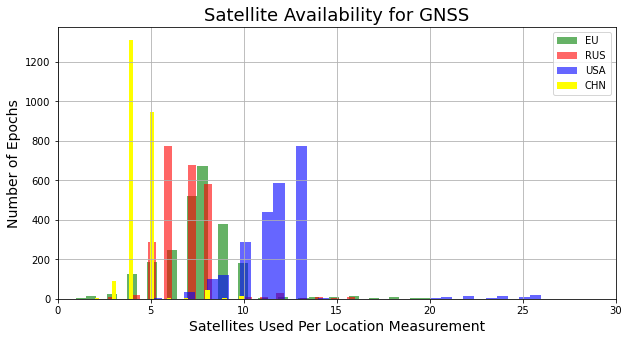

In [38]:
#histogram showing the number of satellites each country used for each measurement, goal is to show availability of satellites 
#this is done with distsinMeters finding calculated at zero because it's a true representation of how many satellites were available, even if there
#wasn't enough to calculate a location (minimum required is 4) 
fig,ax = plt.subplots(figsize=(10,5))
eu_table.constellationType.hist(bins=35,ax=ax,alpha=.6,color='green',label='EU' )
rus_table.constellationType.hist(bins=35, ax=ax,alpha=.6,color='red',label='RUS')
usa_table.constellationType.hist(bins=35, ax=ax,alpha=.6,color='blue',label='USA')
china_table.constellationType.hist(bins=35, ax=ax,alpha=1,color='yellow',label='CHN')
#plt.annotate(str('hi'), ha='center', va='bottom')
ax.set_xlim(0,30)
ax.set_xlabel('Satellites Used Per Location Measurement', fontsize=14)
ax.set_ylabel('Number of Epochs', fontsize=14)
ax.set_title('Satellite Availability for GNSS', fontsize=18)
ax.legend()
plt.savefig('images/Sat Availability per Country')

In [109]:
china_table.constellationType.value_counts()

4     1311
5      947
3       89
8       47
10      15
6        6
9        3
7        3
2        2
Name: constellationType, dtype: int64

In [32]:
#def build_distribution_histogram(column_data,color, figsize_list, bins_int, step_size, ylabel, xlabel,title,imagename):
  #ensure user-provided variables are correct data-type:
    min_int=column_data.min()
    max_int=column_data.max()
    bins_int=int(bins_int)
    step_size=int(step_size)
    ylabel=str(ylabel)
    xlabel=str(xlabel)
    title=str(title)
    imagename=str(imagename)

  #build histogram plot:
    plt.figure(figsize=(figsize_list[0],figsize_list[1]))
    plt.hist(column_data, bins=bins_int, color=str(color))
    plt.xticks(np.arange(min_int, max_int, step=step_size))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    #plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1, label=)
    plt.title(title)
    plt.legend([f'Min Value:{min_int}',f'Max Value:{max_int}'], loc='upper right')
    plt.savefig(f'images/{imagename}' +'.png')
    plt.show()

In [39]:
# build_distribution_histogram(eu_table.constellationType, 'green', [10,5], 35, 2,'Number of Epochs','Satellites Used Per Location Measurement', 'Satellites Used Per Location Measurement','Satellites Used Per Location Measurement' )
# build_distribution_histogram(usa_table.constellationType, 'blue', [10,5], 35, 2,'Number of Epochs','Satellites Used Per Location Measurement', 'Satellites Used Per Location Measurement','Satellites Used Per Location Measurement' )



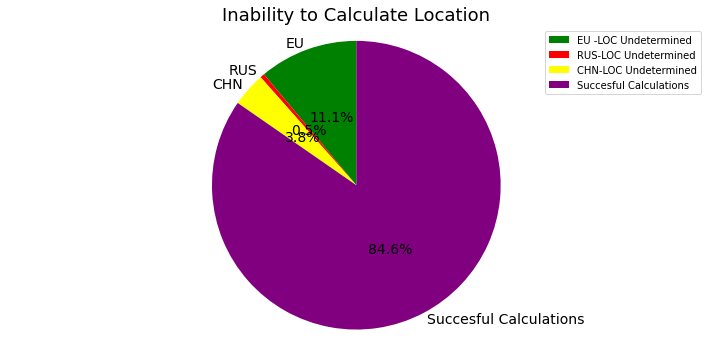

In [28]:
#showing the lack of eu_table.dists_inMeters.value_counts()
eu_inability_to_determine_location= eu_table.dists_inMeters.value_counts()[0.00000] / len(eu_table)
rus_inability_to_determine_location=rus_table.dists_inMeters.value_counts()[0.00000] /len(rus_table)
chn_inability_to_determine_location =china_table.dists_inMeters.value_counts()[0.00000] /len(china_table)
total_pie = len(china_table)/len(china_table) - eu_inability_to_determine_location + rus_inability_to_determine_location+ chn_inability_to_determine_location


failure_labels = ['EU -LOC Undetermined','RUS-LOC Undetermined', 'CHN-LOC Undetermined', 'Succesful Calculations']
failure_sizes = [eu_inability_to_determine_location,rus_inability_to_determine_location, chn_inability_to_determine_location, total_pie ]

def pie_chart_for_column_value_by_percentage(labels, sizes, title, imagename):
    labels = labels
    sizes = sizes
    #explode = (0.1, 0, 0, 0)
    fig1, ax1 = plt.subplots(figsize=(10,5))
    ax1.pie(sizes,  autopct='%1.1f%%',labels=['EU', 'RUS', 'CHN', 'Succesful Calculations'],colors = ['green', 'red','yellow', 'purple'],
        shadow=False, startangle=90, pctdistance=.5, labeldistance=1.05, textprops={'fontsize': 14})
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.legend(bbox_to_anchor=(1.0, 1.0), labels=labels, loc='upper right')
    plt.title(title, fontsize=18)
    plt.savefig('images/' + imagename + '.png')
    plt.tight_layout()
    plt.show()

pie_chart_for_column_value_by_percentage(failure_labels, failure_sizes, 'Inability to Calculate Location', 'Inability to Calculate Location')

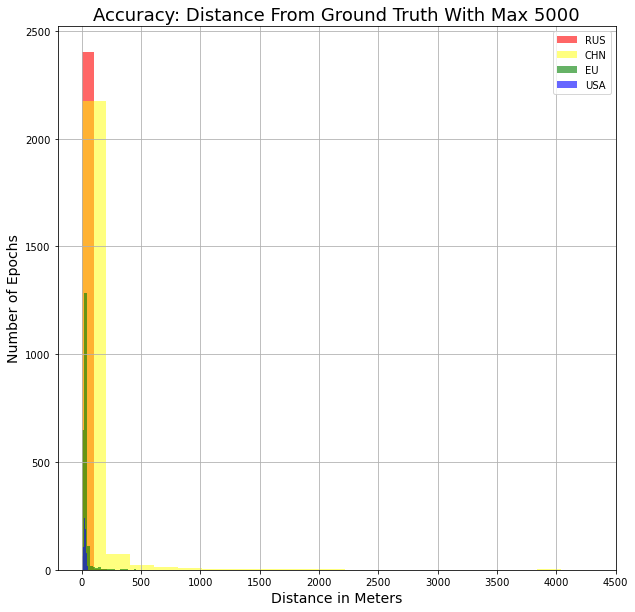

In [50]:
#histogram showing the distance in meters from ground truth, aiming to show how "accurate " each country was 

fig,ax = plt.subplots(figsize=(10,10))

rus_table.query('dists_inMeters >1 and dists_inMeters < 5000').dists_inMeters.hist(bins=20, ax=ax,alpha=.6,color='red',label='RUS')
china_table.query('dists_inMeters >1 and dists_inMeters < 5000').dists_inMeters.hist(bins=20, ax=ax,alpha=.5,color='yellow',label='CHN')
eu_table.query('dists_inMeters >1 and dists_inMeters < 5000').dists_inMeters.hist(bins=20,ax=ax,alpha=.6,color='green',label='EU' )
usa_table.query('dists_inMeters >1 and dists_inMeters < 5000').dists_inMeters.hist(bins=20, ax=ax,alpha=.6,color='blue',label='USA')
#ax.set_xlim(0,30)
ax.set_xlabel('Distance in Meters', fontsize=14)
plt.xticks(np.arange(0, 5000, step=500))
ax.set_ylabel('Number of Epochs', fontsize = 14)
ax.set_title('Accuracy: Distance From Ground Truth With Max 5000', fontsize = 18)
plt.savefig('images/')
ax.legend();

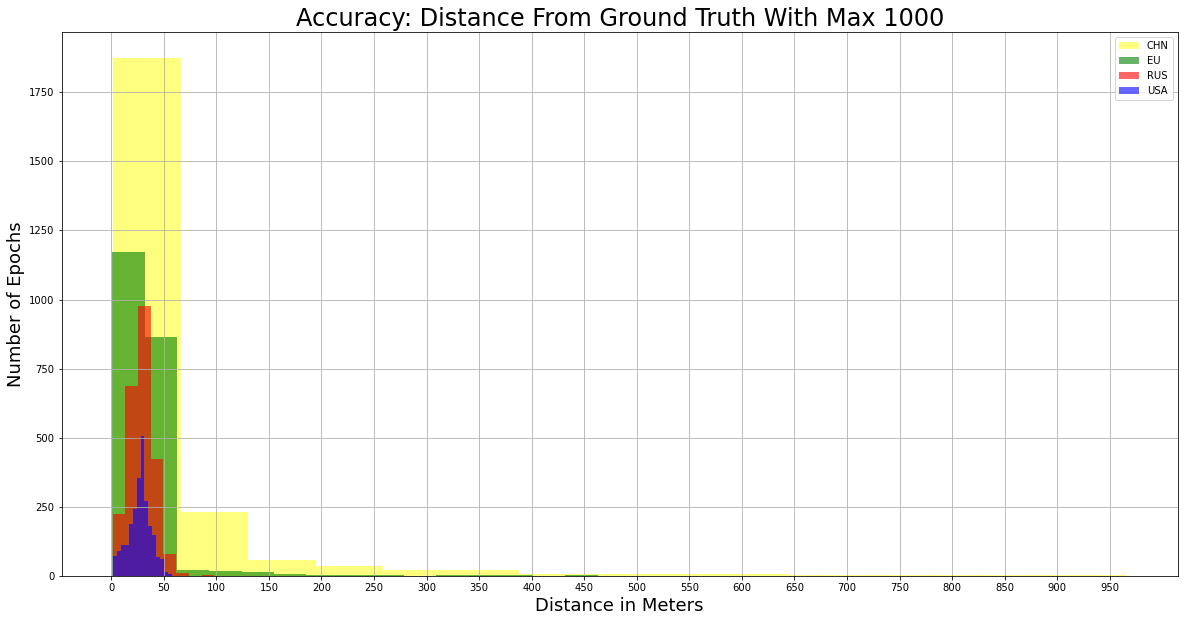

In [111]:
fig,ax = plt.subplots(figsize=(20,10))
china_table.query('dists_inMeters >1 and dists_inMeters < 1000').dists_inMeters.hist(bins=15, ax=ax,alpha=.5,color='yellow',label='CHN')
eu_table.query('dists_inMeters >1 and dists_inMeters < 1000').dists_inMeters.hist(bins=15,ax=ax,alpha=.6,color='green',label='EU' )
rus_table.query('dists_inMeters >1 and dists_inMeters < 1000').dists_inMeters.hist(bins=15, ax=ax,alpha=.6,color='red',label='RUS')
usa_table.query('dists_inMeters >1 and dists_inMeters < 1000').dists_inMeters.hist(bins=15, ax=ax,alpha=.6,color='blue',label='USA')
#ax.set_xlim(0,30)
ax.set_xlabel('Distance in Meters', fontsize=18)
plt.xticks(np.arange(0, 1000, step=50))
ax.set_ylabel('Number of Epochs', fontsize=18)
ax.set_title('Accuracy: Distance From Ground Truth With Max 1000', fontsize=24)
ax.legend();
plt.savefig('images/Accuracy: Distance From Ground Truth With Max 1000')

In [178]:
# Max value for EU distance in Meters: 
eu_table.dists_inMeters.value_counts().index.max()

17388597.87075862

In [205]:
#Max value for CHN distance in Meters:
china_table.dists_inMeters.value_counts().index.max()

SyntaxError: invalid syntax (1666183523.py, line 2)

In [195]:
eu_table.query("(dists_inMeters >= 30) and (constellationType == 4)") 

,constellationType,correctPrM,dists_inMeters,ionoDelayM,isrbM,rawPrM,rawPrUncM,rcvr_bias,residual_error,satClkBiasM,satClkDriftMps,speedMps,timeSinceFirstFixSeconds,tropoDelayM,xSatVelMps,ySatVelMps,zSatVelMps
epoch,,,,,,,,,,,,,,,,,
2393,4,25779319.22200,16272107.93734,6.43850,0.68875,25922940.89625,7.27000,-20677491317.59726,0.01354,-143606.87825,0.00000,12.60000,2549.00000,7.66875,285.35275,-868.68450,-1724.57450
2457,4,25715337.11250,34.77095,6.03150,1.52400,25157052.78475,11.91675,349.17957,0.00000,558298.23750,-0.00475,12.50000,2613.00000,6.35425,1023.27125,-882.27600,-1706.58650
2459,4,24848564.59550,17388597.87076,4.35925,0.73200,24532147.92225,15.88900,-807303182.99315,1.89646,316425.97950,-0.00150,11.78000,2615.00000,4.21500,1290.89025,-1139.97650,-1370.38975
2485,4,25327519.18100,33.22495,4.99600,-5.92650,24974291.50775,9.14350,307.83318,0.00000,353233.40675,-0.00075,0.00000,2641.00000,6.66400,210.62900,-908.87725,314.40275
2486,4,25327342.29175,39.16981,4.99600,-7.71300,24974112.83150,9.36850,311.99158,0.00000,353233.40625,-0.00075,0.00000,2642.00000,6.66300,210.57775,-908.80050,314.12950
2488,4,25326980.92300,30.16061,4.99650,-1.74800,24973757.42750,8.46925,301.97857,0.00000,353233.40475,-0.00075,0.00000,2644.00000,6.66075,210.47625,-908.64650,313.58275
2490,4,25326625.41175,40.82279,4.99625,-7.93550,24973395.72800,9.96800,300.61208,0.00000,353233.40325,-0.00075,0.00000,2646.00000,6.65875,210.37475,-908.49300,313.03650


In [138]:
len(rus_table)
len(eu_table)

2423

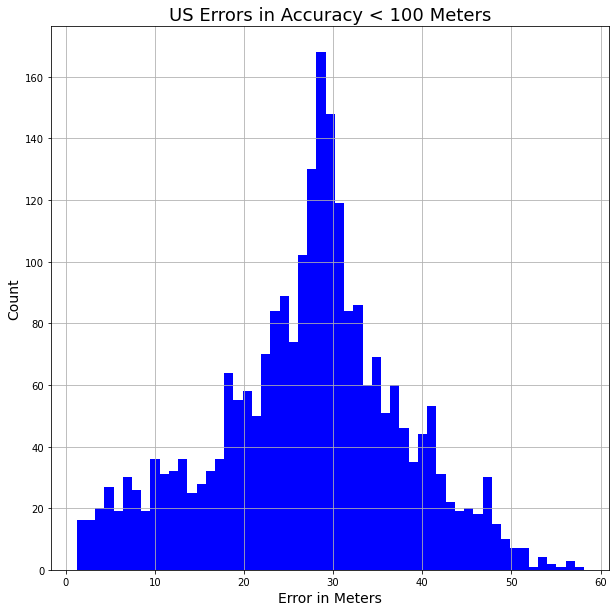

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
usa_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters.hist(bins=55, figsize=(10,10), color='blue')
ax.set_xlabel('Error in Meters', fontsize = 14)
ax.set_ylabel('Count', fontsize = 14)
ax.set_title('US Errors in Accuracy < 100 Meters', fontsize = 18)
plt.savefig('images/US Errors in Accuracy < 100 Meters')

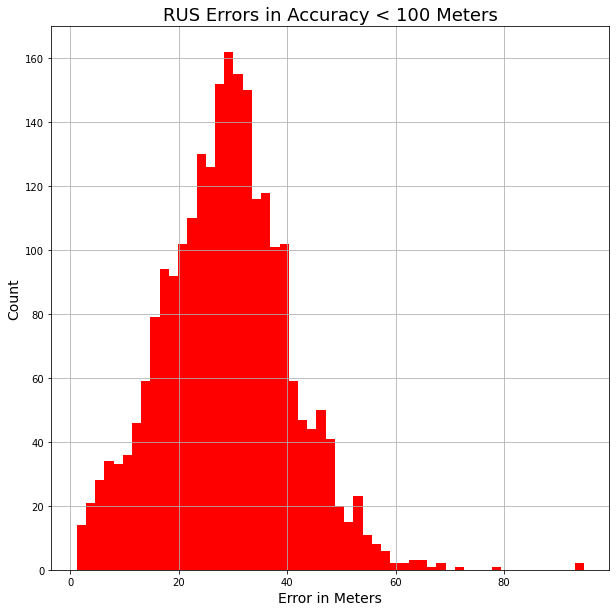

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
rus_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters.hist(bins=55, color='red')
ax.set_xlabel('Error in Meters', fontsize = 14)
ax.set_ylabel('Count', fontsize = 14)
ax.set_title('RUS Errors in Accuracy < 100 Meters', fontsize = 18)
plt.savefig('images/RUS Errors in Accuracy < 100 Meters')

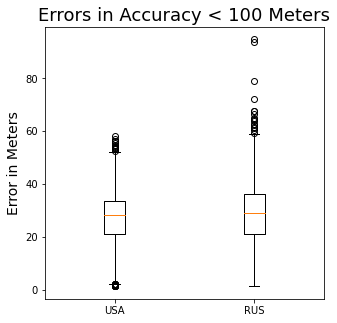

In [89]:
fig,ax = plt.subplots(figsize=(5,5))



ax.boxplot([usa_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters, rus_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters],labels=['USA','RUS'])
#ax.set_ylabel('Count', fontsize = 14 )
ax.set_ylabel('Error in Meters', fontsize = 14)
#plt.xticks(np.arange(0, 100))
ax.set_title('Errors in Accuracy < 100 Meters', fontsize = 18)

fig.savefig('images/Both US and RUS Errors in Accurary.png')

In [93]:

stats.mannwhitneyu(usa_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters,rus_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters, use_continuity=True, alternative='less', axis=0, method='auto')


MannwhitneyuResult(statistic=2702578.0, pvalue=1.5231074818029773e-05)

In [95]:
us_error_mean= np.mean(usa_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters)
us_std = np.std(usa_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters)
rus_error_mean= np.mean(rus_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters)
rus_std= np.std(rus_table.query('dists_inMeters >1 and dists_inMeters < 100').dists_inMeters)

In [96]:
print(f'us_mean: {us_error_mean}')
print(f'us_std:  {us_std}')
print(f' rus: {rus_error_mean}')
print(f' us_std: {rus_std}')

us_mean: 27.10792988449431
us_std:  10.540525907637699
 rus: 28.774800154530215
 us_std: 11.625758239947974


In [ ]:
stats.ttest_ind(cars_df[cars_df.car_makes=='ford'].horsepower.dropna(),cars_df[cars_df.car_makes=='chevrolet'].horsepower.dropna(),equal_var=True,alternative='greater')
